In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 614kB 9.1MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from IPython.display import clear_output
from copy import deepcopy

import sys
root = '/content/drive/MyDrive/BayesianMatrixNeuralNetworks/CyclonePrediction/'
sys.path.append(root)

for module in ['util', 'models']:
  if module in sys.modules:  
    print(f'Deleting {module}')
    del sys.modules[module]

from models import MatrixNetwork, make_bayes_model
from util import load_data_as_tensor, gradient_descent

import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal

Mounted at /content/drive


# Data
- can use argument use_gpu=True

In [5]:
use_gpu = False
if use_gpu == True:
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data_as_tensor(root + "data/", use_gpu=use_gpu)

# Best model search for matrix NN

In [ ]:
epochs = 10000
patience = 500

In [ ]:
param_dict = {
    'hidden_dim': [(10, 10), (20, 20), (50, 50)],
    'n_hidden_layers': [1, 2, 3]
}

In [ ]:
df_loss = pd.DataFrame({'params': [], 'loss': []})

params = {k: v[0] for k, v in param_dict.items()}
criterion = nn.MSELoss()

for key in param_dict:
  best_loss = np.Inf
  for val in param_dict[key]:
    params[key] = val
    print(params)
    
    model = MatrixNetwork(**params)
    if use_gpu:
      model.cuda()

    model, _, _, _ = gradient_descent(epochs, model, X_train, y_train, X_val, y_val, 
                                      patience=patience, checkpoint_path=root + "models/checkpoint.pt")

    model.eval()
    y_pred_test = model(X_test)
    test_loss = criterion(y_pred_test, y_test)

    df_loss.append({'params': params, 'loss': test_loss}, ignore_index=True)

    if test_loss.item() < best_loss:
      best_loss = test_loss.item()
      best_param = val
      torch.save(model.state_dict(), root + "models/best_MNN.pt")

    clear_output(wait=True)
  params[key] = val

df_loss.pickle(root + "results/loss_MNN")

model = MatrixNetwork(**params)
model.load_state_dict(torch.load(root + "models/best_MNN.pt"))

{'hidden_dim': (50, 50), 'n_hidden_layers': 3}
Done: 1000 / 10000 epochs
Train loss: 0.05188374221324921
Val loss: 0.08982708305120468
Time taken: 96.48106908798218
Done: 2000 / 10000 epochs
Train loss: 0.03610772266983986
Val loss: 0.06288275867700577
Time taken: 191.66325330734253
Done: 3000 / 10000 epochs
Train loss: 0.033332958817481995
Val loss: 0.059004299342632294
Time taken: 285.36181473731995
Stopping early


# Visualise predictions from gradient descent

In [7]:
params = {'hidden_dim': (50, 50), 'n_hidden_layers': 3}
model = MatrixNetwork(**params)
model.load_state_dict(torch.load(root + "models/best_MNN.pt"))

with open(root + "data/X_split_test.pkl", "rb") as r:
  X_split_test = pickle.load(r)

with open(root + "data/y_split_test.pkl", "rb") as r:
  y_split_test = pickle.load(r)

<All keys matched successfully>

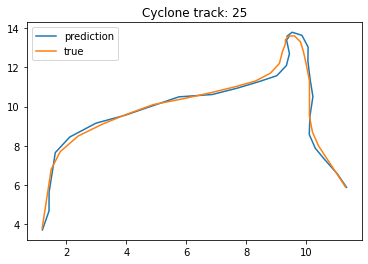

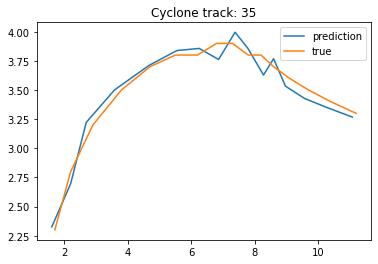

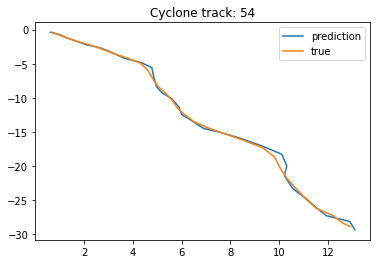

In [22]:
for i in range(3):
  rand_idx = np.random.choice(range(len(y_split_test)))

  X_test_inst = torch.tensor(X_split_test[rand_idx]).type(torch.float)
  y_test_inst = y_split_test[rand_idx]

  model.eval()
  y_pred_test_inst = model(X_test_inst).detach().numpy()

  plt.figure()
  plt.title(f"Cyclone track: {rand_idx}")
  plt.plot(y_pred_test_inst[:, 0], y_pred_test_inst[:, 1], label="prediction")
  plt.plot(y_test_inst[:, 0], y_test_inst[:, 1], label="true")
  plt.legend()